# Исследование рынка заведений общественного питания Москвы

# Цель
Проанализировать рынок общественного питания Москвы 
## Данные
Данные будем запрашивать с помощью api информационного ресурса "Портал откртых данных"  https://data.mos.ru 
## Ход исследования
1) Получение данных
2) Обзор и предобработка данных
3) Анализ данных
   * плотность сетевых несетевых заведений
   * посадочные места в заведениях
   * расположение заведений
5) Вывод

In [2]:
import requests
import pandas as pd
import numpy as np
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import time

import geopandas as gpd
import shapely
from shapely.ops import snap, unary_union
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import plotly.express as px

## Получение данных 

In [3]:
session=requests.Session()

In [5]:
def get_requests(url:str,params:dict=None):
    if params:
        return session.get(url,params=params).json()
    else:
        return session.get(url).json()

In [7]:
#узнаем к какой категории относится общественное питание на этом сервере
url=f'https://apidata.mos.ru/v1/categories?api_key={api_key}'

params={
    '$inlinecount':True #чтобы получить общее кол-во записей 
}

data=get_requests(url,params)

In [8]:
#из массива категорий найдем данные для Общественного питания
catering=[]
for item in data['categories']:
    if item['Name']== 'Общественное питание':
        catering=item
        break
#нам вернулся словарь по ключу Datasets лежит список наборов данных относящихся к категории и структура хранения данных

In [9]:
#проходимся по каждому департаменту и заносим значения в словарь,для дальнейшего Датасета
results={}

for i in catering['Datasets']:
    
    batch_size=1000 #максимальный размер массивы который можем получить за 1 запрос
    
    url=f'https://apidata.mos.ru/v1/datasets/{i}/count?api_key={api_key}'
    count=get_requests(url) #кол-во элементов в i категории
    
    get_count=min(count,batch_size)
    
    if(get_count>0):
        
        for j in range(0,count,get_count): #так как за раз мы не можем считать больше 1000 данных то разделим это дейсвтие на несколько иттераций
        
            params={
                    '$skip': j,
                    '$top': batch_size
                }
        
            url1=f'https://apidata.mos.ru/v1/datasets/{i}/rows?api_key={api_key}'#получим данные о заведениях в i департаменте
            response=get_requests(url1,params)
    
            for item in  response:#добавляем в словарь значения по каждому ключу
                for key, value in item['Cells'].items():
                    if key not in results.keys():
                        results[key]=[value]
                    else:
                        results[key].append(value)

        
        time.sleep(5)
        
DF=pd.DataFrame(results)
DF.to_csv('get_data.csv',index=False)

обзор и предоброботка данных

In [12]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39362 entries, 0 to 39361
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   global_id         39362 non-null  int64 
 1   ID                39362 non-null  object
 2   Name              39362 non-null  object
 3   IsNetObject       39362 non-null  object
 4   OperatingCompany  39362 non-null  object
 5   TypeObject        39362 non-null  object
 6   AdmArea           39362 non-null  object
 7   District          39362 non-null  object
 8   Address           39362 non-null  object
 9   PublicPhone       39362 non-null  object
 10  SeatsCount        39362 non-null  int64 
 11  SocialPrivileges  39362 non-null  object
 12  Longitude_WGS84   39362 non-null  object
 13  Latitude_WGS84    39362 non-null  object
 14  geoData           39362 non-null  object
dtypes: int64(2), object(13)
memory usage: 4.5+ MB


Как видим,пропущенных значений в анализируемом датасете нет, значит можно приступать к следующему этапу - обзор и предобработка данных

В полях  Longitude_WGS84  Latitude_WGS84 лежит информация о широте и долготе для дальнейшей работы необходимо преобразовать данные
в объекты типа shapely.geometry.Point для нанесения заведений на карту

In [268]:
DF.drop(columns={'geoData'},inplace=True)
DF['geoData'] = gpd.points_from_xy(DF['Longitude_WGS84'], DF['Latitude_WGS84'])
DF.drop(columns={'Longitude_WGS84','Latitude_WGS84'},inplace=True)
DF.drop(columns='OperatingCompany',inplace=True)
DF['District']=DF['District'].str.replace('район','')

Рассматим какие именно типы заведений  предоставлены в датасете

In [18]:
DF['TypeObject'].unique() 

array(['буфет', 'столовая', 'кафе', 'закусочная',
       'предприятие быстрого обслуживания', 'бар', 'ресторан',
       'кафетерий', 'магазин (отдел кулинарии)',
       'ночной клуб (дискотека)', 'заготовочный цех'], dtype=object)

Найдем в полученном датасете заведения,которые относятся к одной сети,но имеют разные названия

In [17]:
DF.groupby('Name').agg({'ID': 'nunique'}).sort_values(by='ID', ascending=False).head(50)

,ID
Name,
Шаурма,619
Столовая,382
Кафе,335
Милти,285
Буханка,283
KFC,263
Пекарня,233
Cofix,227
Шоколадница,210


видим что есть неяные дубликаты сабвей и subway,вкусно и точки и макдоналдс и вкусно- и точка,

In [86]:
DF['Name']=DF['Name'].str.replace('сабвей','subway').str.replace('МАКДОНАЛДС','вкусно и точка').\
        str.replace('Вкусно - и точка','вкусно и точка').str.replace('Ростикс KFC','KFC').\
        str.replace("Домино'с Пицца",'Домино Пицца')

# Анализ данных

Проанализируем какие именно объекты питания существуют в городе и их процентное отношение ко всем заведениям в городе

In [23]:
new_data=DF.groupby('TypeObject').agg(establishment=('ID','count')).reset_index().sort_values(by='establishment',ascending=False)
new_data['percentage of total']=round(new_data['establishment']/sum(new_data['establishment']) *100,2)
new_data

,TypeObject,establishment,percentage of total
4,кафе,14450,36.71
8,предприятие быстрого обслуживания,6413,16.29
9,ресторан,4920,12.50
10,столовая,4292,10.90
5,кафетерий,3410,8.66
0,бар,2617,6.65
3,закусочная,1119,2.84
1,буфет,1039,2.64
6,магазин (отдел кулинарии),830,2.11
2,заготовочный цех,183,0.46


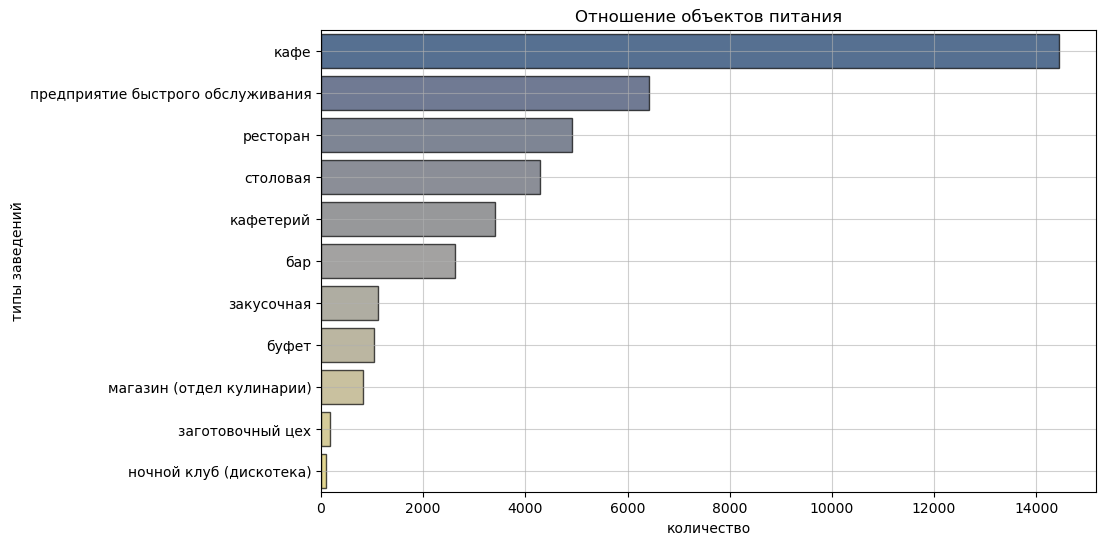

In [24]:
plt.figure(figsize=(10,6))
ax=sns.barplot(data=new_data,x='establishment',y='TypeObject',hue='TypeObject',palette="cividis",alpha=0.7,edgecolor='black')
ax.set_title('Отношение объектов питания')
ax.set_xlabel('количество')
ax.set_ylabel('типы заведений')
plt.grid(alpha=0.6)
plt.show()

По графику можно заметить ,что большую часть заведений в городе занимают кафе,общее кол-во занимает больше 14к заведений в городе,
что составляет 36,72%;Значительно меньше преприятий быстрого обслуживания, но по количеству заведений в городе(6413 или 16,29%) занимают    2-ое место. Меньше всего заведений такого тип как ночной клуб,меньше 1% от всех заведений в городе

## Анализ плотности сетевых и несетвых заведений

In [94]:
new_data=DF.groupby('IsNetObject').agg(count=('ID','count')).reset_index()
new_data

,IsNetObject,count
0,да,7450
1,нет,31912


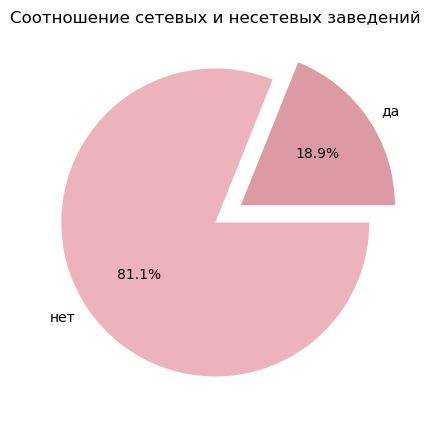

In [33]:
plt.figure(figsize=(10,5))
plt.pie(new_data['count'],
        labels=new_data['IsNetObject'],
        explode=[0.2,0],
        colors=['#DC9AA5', '#EDB3BD'],
        autopct='%1.1f%%'
       )
plt.title('Соотношение сетевых и несетевых заведений')
plt.show()

В городе преобладают несетевые заведения и составляют 81,1% от общего числа заведений в городе , а  именно 31912

Рассмотрим в разрезе сколько несетевых и несетевых заведений в каждом из типов заведений

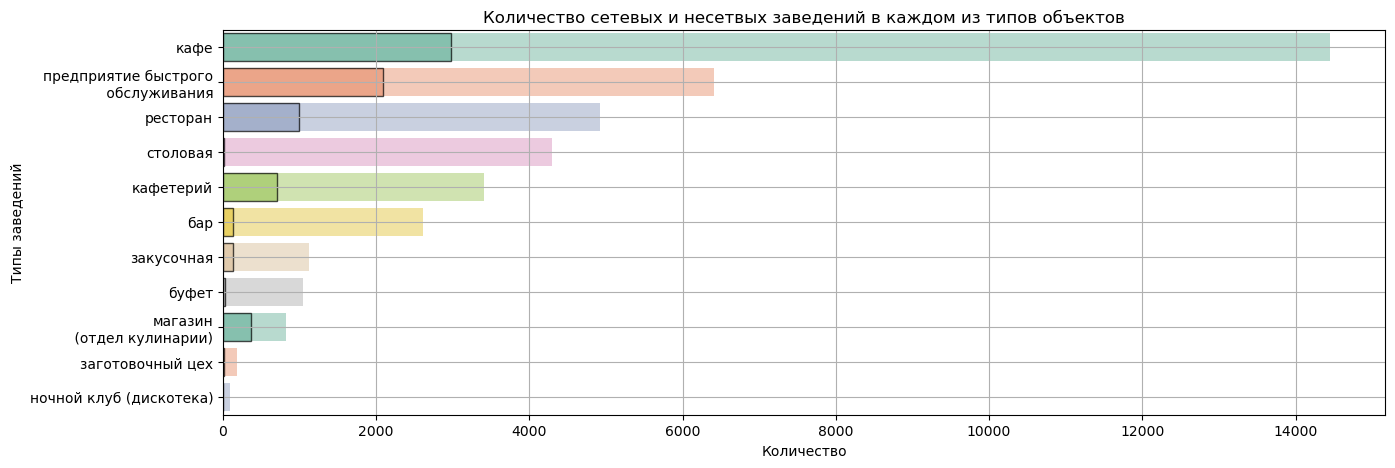

In [314]:
data=DF.groupby('TypeObject').agg(all_count=('Name','count')).reset_index().sort_values(by='all_count',ascending=False)
not_net_counts = DF[DF['IsNetObject'] == 'да'].groupby('TypeObject').size()
data['NetObject'] = data['TypeObject'].map(not_net_counts).fillna(0)
plt.figure(figsize=(15,5))
sns.barplot(data=data,y=data['TypeObject'],
            x=data['all_count'],
            hue=data['TypeObject'],
            palette=sns.color_palette('Set2', n_colors=11),
           alpha=0.5)

sns.barplot(data=data,y=data['TypeObject'],
            x=data['NetObject'],
            hue=data['TypeObject'],
            palette=sns.color_palette('Set2', n_colors=11),
           alpha=0.7,
           edgecolor='black')

plt.title('Количество сетевых и несетвых заведений в каждом из типов объектов')
plt.xlabel('Количество')
plt.ylabel('Типы заведений')
plt.grid()
plt.show()

Рассчитаем сколько именно % от общего числа заведений в определнной категории составляют сетевые заведения

In [328]:
data['percent_in_type']=round(data['NetObject']/data['all_count']*100,2)
data=data.sort_values(by='percent_in_type',ascending=False)
data

,TypeObject,all_count,NetObject,percent_in_type
6,магазин\n (отдел кулинарии),830,363,43.73
8,предприятие быстрого\n обслуживания,6413,2084,32.50
5,кафетерий,3410,710,20.82
4,кафе,14450,2981,20.63
9,ресторан,4920,996,20.24
3,закусочная,1119,128,11.44
0,бар,2617,137,5.24
2,заготовочный цех,183,8,4.37
7,ночной клуб (дискотека),89,3,3.37
1,буфет,1039,26,2.50


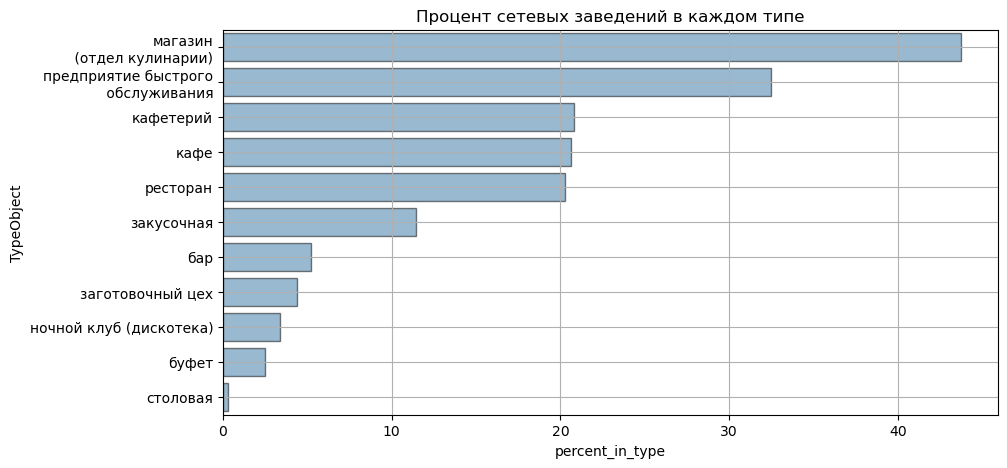

In [327]:
plt.figure(figsize=(10,5))
sns.barplot(data=data,
            x='percent_in_type',
            y='TypeObject',
            edgecolor='black',
            alpha=0.5
           )
plt.title('Процент сетевых заведений в каждом типе')
plt.grid()
plt.show()

Для начала рассмотрим тенденции в каждой категории к созданию сети , видим что в таких категориях как магазин(отдел кулинарии)  
и предприятия быстрого обслуживания сети составляют 43.73% и 33%,что больше чем в любой другой сети. Наименьшие показзатели по созданию сетей наблюдаются в заведениях типа столовая и буфеты. 

В типах заведений которые наиболее распространены в городе в таких как кафе,предприятия быстрого обслуживания,рестораны
создание сетей не так распрастранено и  % сетевых заведений в категориях составляет 20.63% , 32.50%, 20.24%.

Рассмотрим какие именно заведениях в наиболее распространенных типах заведений образуют сети

In [97]:
result=DF.query(" TypeObject in ['кафе','предприятие быстрого обслуживания','ресторан'] and IsNetObject == 'да' ").\
    groupby(['TypeObject','Name']).agg(count=('ID','count')).reset_index().sort_values(by='count',ascending=False)
result.sort_values(by='count',ascending=False).head(50)

,TypeObject,Name,count
659,предприятие быстрого обслуживания,вкусно и точка,322
477,предприятие быстрого обслуживания,KFC,298
452,кафе,Шоколадница,283
516,предприятие быстрого обслуживания,Бургер Кинг,242
571,предприятие быстрого обслуживания,Крошка Картошка,157
651,предприятие быстрого обслуживания,Теремок,142
171,кафе,Додо Пицца,124
132,кафе,Буханка,119
306,кафе,Мята Lounge,103
173,кафе,Домино Пицца,98


как видим в Москве чаще всего сети образуют такие заведения как вкусно и точка, KFC, Шоколадница и тп
Что очень даже схоже с реальностью.

## Анализ посадочных мест в заведениях

Сначала рассмотрим общий разброс мест в заведениях города,а затем в разрезе по каждой категории

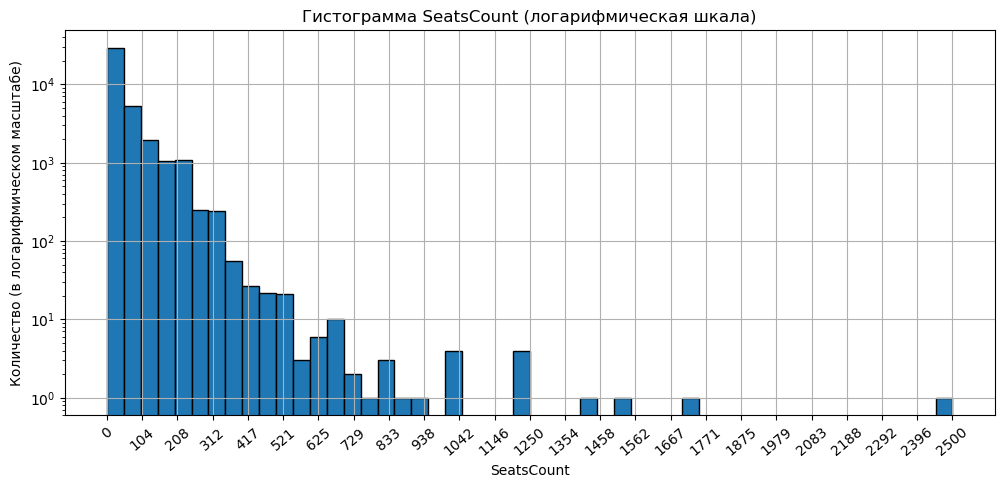

[2.9401e+04 5.2650e+03 1.9210e+03 1.0490e+03 1.0710e+03 2.5100e+02
 2.3900e+02 5.6000e+01 2.7000e+01 2.2000e+01 2.1000e+01 3.0000e+00
 6.0000e+00 1.0000e+01 2.0000e+00 1.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 4.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00]


In [156]:
plt.figure(figsize=(12,5))
n,bins,p=plt.hist(DF['SeatsCount'],bins=50,edgecolor='black')
plt.yscale('log')# чтобы отобразить полную картину
plt.xlabel("SeatsCount")
plt.ylabel("Количество (в логарифмическом масштабе)")
plt.xticks(np.linspace(min(bins),max(bins),25),rotation=40)
plt.title("Гистограмма SeatsCount (логарифмическая шкала)")
plt.grid()
plt.show()
print(n)

In [ ]:
Больше всего заведений(29401) имеют посадочных мест в интервале [0,52], так же наблюдаются 
единичные выбросы в которых в заведениях наблюдается колосально большое кол-во посадочных мест ~2500, ~1719,~1406.
Так же можно заметить что с ростом кол-во посадочных мест снижается кол-во заведений обладающих таким числом.

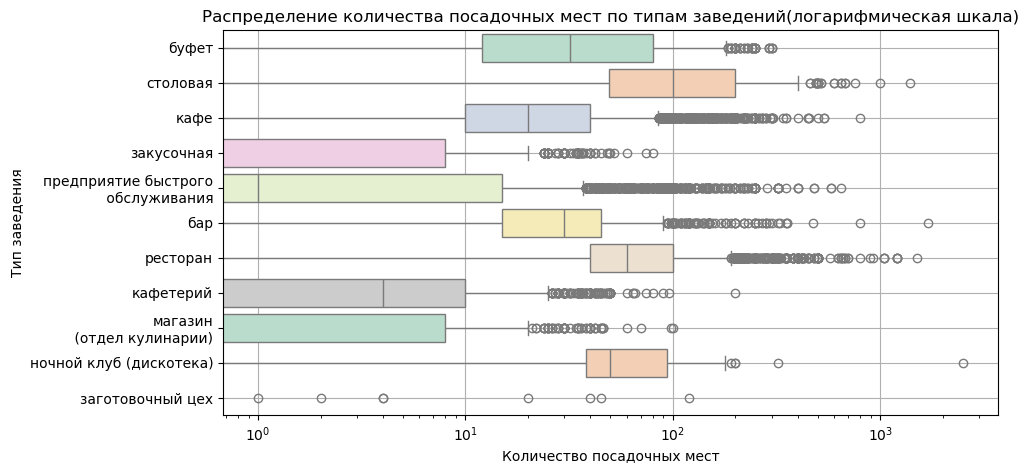

In [242]:
DF['TypeObject']=DF['TypeObject'].replace(
    ['предприятие быстрого обслуживания', 'магазин (отдел кулинарии)'], 
    ['предприятие быстрого\n обслуживания', 'магазин\n (отдел кулинарии)'])

plt.figure(figsize=(10,5))
sns.boxplot(data=DF, y='TypeObject', x='SeatsCount',hue='TypeObject',palette='Pastel2')
plt.title("Распределение количества посадочных мест по типам заведений(логарифмическая шкала)")
plt.ylabel('Тип заведения')
plt.xlabel('Количество посадочных мест')
plt.xscale('log')#чтобы отобразить полную картину
plt.grid()
plt.show()

Как видно отмечается значительная вариативность в количестве посадочных мест между разными типами заведений.Так же видим что 
тип заведения оказывается существенное влияние на кол-во посадочных мест. Но в каждом из типов заведений встречаются выбросы ,
выходящих за рамки типичных размеров для своей категории.

Теперь рассмотрим в разрере сетевых/несетевых каждый тип заведения

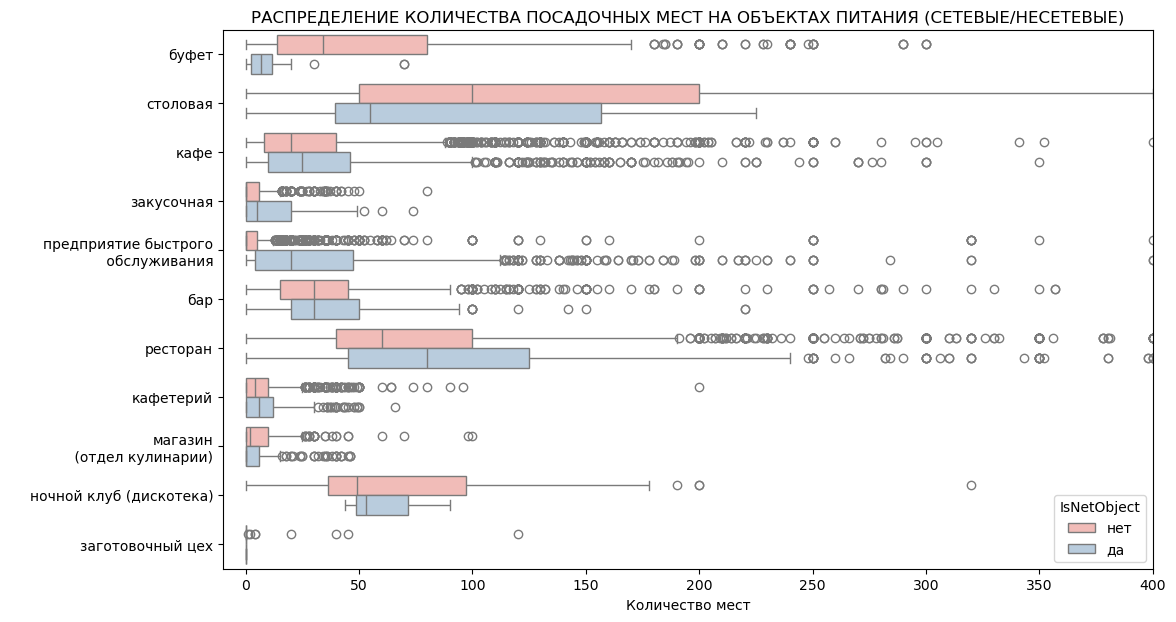

In [223]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='SeatsCount', y='TypeObject', data=DF, hue='IsNetObject', palette='Pastel1')
plt.xlim(-10,400)
plt.title('РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА ПОСАДОЧНЫХ МЕСТ НА ОБЪЕКТАХ ПИТАНИЯ (СЕТЕВЫЕ/НЕСЕТЕВЫЕ)')
plt.xlabel('Количество мест')
plt.ylabel(' ') 
plt.show()

Как видим в среднем число посадочных мест в сетевых заведениях больше чем в несетевых.
Кроме таких типов заведений как буфет,столовая и ночной клуб.

Теперь рассмотрим среднее количество мест в сетевых и несетевых заведениях

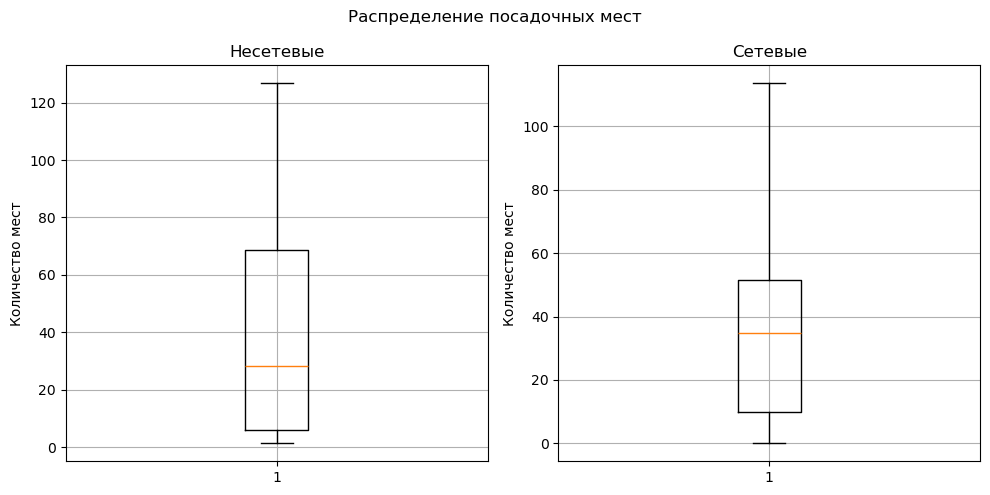

In [218]:
result = pd.pivot_table(DF, values='SeatsCount', index='TypeObject', columns='IsNetObject', aggfunc='mean', fill_value=0).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].boxplot(result['нет'])  
axes[0].set_title('Несетевые') 
axes[0].set_ylabel('Количество мест')
axes[0].grid()

# Второй boxplot (сетевые)
axes[1].boxplot(result['да']) 
axes[1].set_title('Сетевые')
axes[1].set_ylabel('Количество мест')
axes[1].grid()
fig.suptitle('Распределение посадочных мест')

plt.tight_layout()
plt.show()

Ящик в несетевых заведениях длиннее, что указывает на больший разброс в количестве посадочных мест между 25% и 75% заведениями. То есть 50% несетевых заведений имеют большее разнообразие в количестве посадочных мест.
Длинный верхний ус говорит о том, что среди 25% заведений с наибольшим количеством посадочных мест (выше Q3) также наблюдается большой разброс. То есть есть несетевые заведения, количество посадочных мест которых значительно превышает типичные значения.
Короткий нижний ус указывает на то, что среди 25% заведений с наименьшим количеством посадочных мест (ниже Q1) разброс небольшой. Большинство несетевых заведений с малым количеством посадочных мест имеют примерно одинаковое их число.
Таким образом, можно сказать что 50% несетевых заведений укладываются в диапазон [5;70], верхние 25% имеют тенденцию располагаться далеко за границей 70 а нижние 25% очень тесно прижаты к 5

Ящик в сетевых заведениях короче, что означает меньший разброс в количестве посадочных мест между 25% и 75% заведениями. 50% сетевых заведений имеют более предсказуемое и ограниченное количество посадочных мест.
Верхний ус длиннее, чем в несетевых заведениях. Это говорит о том, что даже при меньшем разбросе в основной массе данных (ящик), сетевые заведения с очень большим количеством посадочных мест встречаются чаще, чем в несетевых. То есть выбросов тут будет явно больше и они дальше находятся
Нижний ус длиннее, чем в несетевых. Это значит, что у сетевых заведений больший разброс в меньших значениях.
Таким образом можно сказать что 50% сетевых заведений укладываются в диапазон [10;50], верхние 25% имеют тенденцию располагаться далеко за границей 50 а нижние 25% имеют тенденцию располагаться дальше нуля, но опять же не уходят далеко



Теперь посмотрим существует ли зависимость кол-во посадочных мест от кол-во заведений в сети

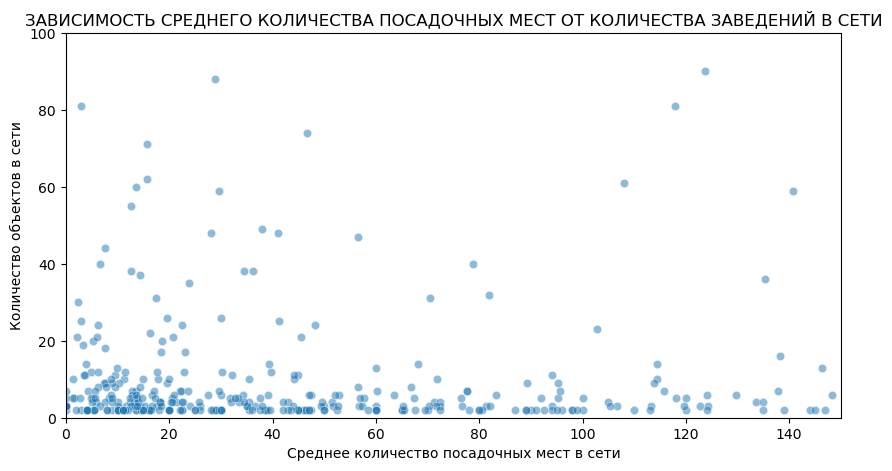

In [238]:
data= DF.query("IsNetObject == 'да' ").groupby(['Name']).agg(count=('ID', 'count'), mean=('SeatsCount','mean'))
plt.figure(figsize=(10, 5))
plt.ylim(0, 100) 
plt.xlim(0, 150)# Можно посмотреть поближе в левый нижний угол
plt.title('ЗАВИСИМОСТЬ СРЕДНЕГО КОЛИЧЕСТВА ПОСАДОЧНЫХ МЕСТ ОТ КОЛИЧЕСТВА ЗАВЕДЕНИЙ В СЕТИ')
sns.scatterplot(x = 'mean', 
                y = 'count',
                alpha = 0.5,
                data = data[data['count'] >= 2])
plt.xlabel('Среднее количество посадочных мест в сети')
plt.ylabel('Количество объектов в сети')
plt.show()


Видим,что явных зависимостей нет, но есть скопление заведений в нижнем левом углу,то есть небольшое кол-во посадочных мест и
небольшое кол-во заведений в сети.

## Анализ расположения заведений

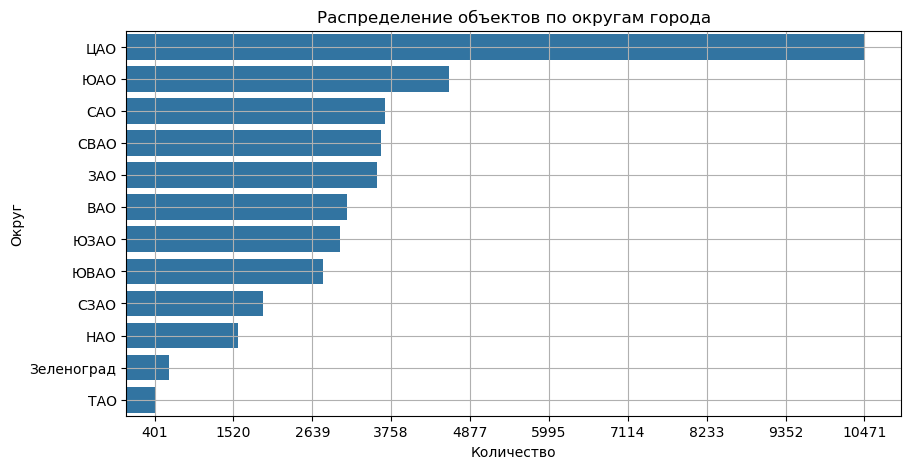

In [329]:
admarea_map = {
    'Центральный административный округ': 'ЦАО',
    'Южный административный округ': 'ЮАО',
    'Северный административный округ': 'САО',
    'Северо-Восточный административный округ': 'СВАО',
    'Западный административный округ': 'ЗАО',
    'Восточный административный округ': 'ВАО',
    'Юго-Западный административный округ': 'ЮЗАО',
    'Юго-Восточный административный округ': 'ЮВАО',
    'Северо-Западный административный округ': 'СЗАО',
    'Новомосковский административный округ': 'НАО',
    'Зеленоградский административный округ': 'Зеленоград',
    'Троицкий административный округ': 'ТАО'
}

data=DF.groupby('AdmArea').agg(count=('ID','count')).reset_index().sort_values(by='count',ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='count',
            y=data['AdmArea'].map(admarea_map),
           errorbar=None,
            data=data)
plt.xticks(np.linspace(min(data['count']),max(data['count']),10))
plt.xlabel('Количество')
plt.ylabel('Округ')
plt.grid(axis='both')
plt.title('Распределение объектов по округам города')
plt.show()

Видим,что наибольшее кол-во заведений сконцентрировано именно в ЦАО(Центральный административный округ)

In [333]:
data['percent']=data['count']/sum(data['count'])*100
data

,AdmArea,count,percent
8,Центральный административный округ,10471,26.601799
11,Южный административный округ,4577,11.627966
4,Северный административный округ,3666,9.313551
5,Северо-Восточный административный округ,3618,9.191606
1,Западный административный округ,3557,9.036634
0,Восточный административный округ,3127,7.944210
10,Юго-Западный административный округ,3028,7.692699
9,Юго-Восточный административный округ,2785,7.075352
6,Северо-Западный административный округ,1938,4.923530
3,Новомосковский административный округ,1591,4.041969


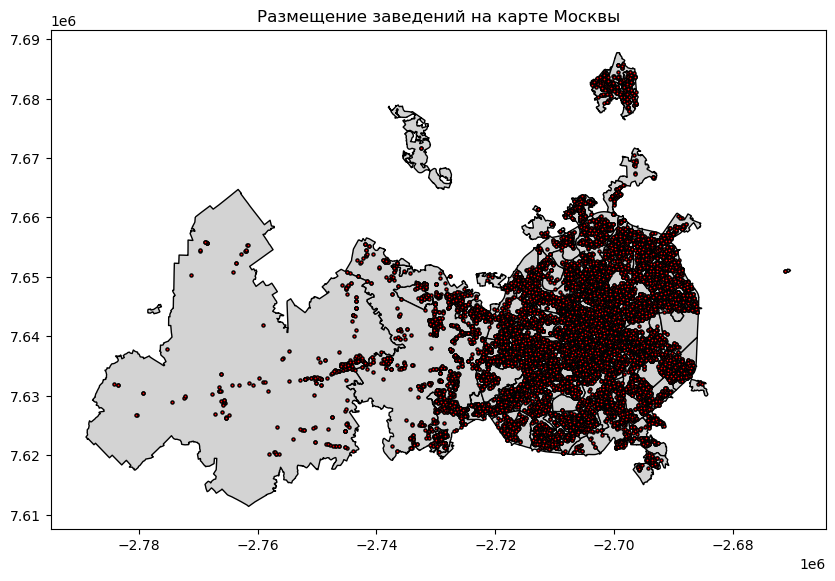

In [259]:
# Читаем базовую карту Москвы
DF_geo = gpd.read_file('Moscow.geojson')
DF_geo = DF_geo.to_crs('EPSG:32646')
gdf_cities = gpd.GeoDataFrame(DF, geometry=DF['geoData'],crs="EPSG:4326")
gdf_cities = gdf_cities.to_crs(DF_geo.crs)
fig, ax = plt.subplots(figsize=(10, 10))
DF_geo.plot(ax=ax, color='lightgray', edgecolor='black')
gdf_cities.plot(ax=ax, marker='.', color='red', markersize=20, label='Города',edgecolor='black')
plt.title('Размещение заведений на карте Москвы')
plt.show()


Так как по этой карте очень сложно определить округи и сделать хоть какой-то вывод,то разделим карту на округи

Так как по этой карте очень сложно ориентироваться и делать выводы,то разобьем эту карту на округи и будем ориентировться по ним
1) Распишем какой район к какому округу относится
2) И относительно этого каждому из районов(которые прописаны в адресе) пропишем некий округ

In [247]:
district_to_okrug = {
    # Центральный административный округ (ЦАО)
    "Арбат": "ЦАО", "Басманный": "ЦАО", "Замоскворечье": "ЦАО", "Красносельский": "ЦАО",
    "Мещанский": "ЦАО", "Пресненский": "ЦАО", "Таганский": "ЦАО", "Тверской": "ЦАО",
    "Хамовники": "ЦАО", "Якиманка": "ЦАО",

    # Северный административный округ (САО)
    "Аэропорт": "САО", "Беговой": "САО", "Бескудниковский": "САО", "Войковский": "САО",
    "Восточное Дегунино": "САО", "Головинский": "САО", "Дмитровский": "САО",
    "Западное Дегунино": "САО", "Коптево": "САО", "Левобережный": "САО",
    "Молжаниновский": "САО", "Савеловский": "САО", "Сокол": "САО",
    "Тимирязевский": "САО", "Ховрино": "САО","Хорошевский":"САО",

    # Северо-Восточный административный округ (СВАО)
    "Алексеевский": "СВАО", "Алтуфьевский": "СВАО", "Бабушкинский": "СВАО",
    "Бибирево": "СВАО", "Бутырский": "СВАО", "Лианозово": "СВАО",
    "Лосиноостровский": "СВАО", "Марфино": "СВАО", "Марьина роща": "СВАО",
    "Останкинский": "СВАО", "Отрадное": "СВАО", "Ростокино": "СВАО",
    "Свиблово": "СВАО", "Северное Медведково": "СВАО", "Южное Медведково": "СВАО",
    "Ярославский": "СВАО",

    # Восточный административный округ (ВАО)
    "Богородское": "ВАО", "Вешняки": "ВАО", "Восточный": "ВАО", "Гольяново": "ВАО",
    "Ивановское": "ВАО", "Восточное Измайлово": "ВАО", "Косино-Ухтомский": "ВАО",
    "Метрогородок": "ВАО", "Новогиреево": "ВАО", "Новокосино": "ВАО",
    "Перово": "ВАО", "Преображенское": "ВАО", "Соколиная Гора": "ВАО",
    "Сокольники": "ВАО","Северное Измайлово":"ВАО", 'Измайлово':"ВАО",
    "Соколиная гора" : "ВАО",

    # Юго-Восточный административный округ (ЮВАО)
    "Выхино-Жулебино": "ЮВАО", "Капотня": "ЮВАО", "Кузьминки": "ЮВАО",
    "Лефортово": "ЮВАО", "Люблино": "ЮВАО", "Марьино": "ЮВАО", "Некрасовка": "ЮВАО",
    "Нижегородский": "ЮВАО", "Печатники": "ЮВАО", "Рязанский": "ЮВАО",
    "Текстильщики": "ЮВАО",'Южнопортовый':'ЮВАО',

    # Южный административный округ (ЮАО)
    "Бирюлёво Восточное": "ЮАО", "Бирюлево Западное": "ЮАО", "Братеево": "ЮАО",
    "Даниловский": "ЮАО", "Донской": "ЮАО", "Зябликово": "ЮАО", "Москворечье-Сабурово": "ЮАО",
    "Нагатино-Садовники": "ЮАО", "Нагатинский Затон": "ЮАО", "Нагорный": "ЮАО",
    "Орехово-Борисово Северное": "ЮАО", "Орехово-Борисово Южное": "ЮАО",
    "Царицыно": "ЮАО", "Чертаново Северное": "ЮАО", "Чертаново Центральное": "ЮАО",
    "Чертаново Южное": "ЮАО","Нагатинский затон":'ЮАО','Бирюлево Восточное':"ЮАО",

    # Юго-Западный административный округ (ЮЗАО)
    "Академический": "ЮЗАО", "Гагаринский": "ЮЗАО", "Зюзино": "ЮЗАО",
    "Коньково": "ЮЗАО", "Котловка": "ЮЗАО", "Ломоносовский": "ЮЗАО",
    "Обручевский": "ЮЗАО", "Северное Бутово": "ЮЗАО", "Тёплый Стан": "ЮЗАО",
    "Черёмушки": "ЮЗАО", "Южное Бутово": "ЮЗАО", "Ясенево": "ЮЗАО",
    'Теплый Стан' :"ЮЗАО" , 'Черемушки':'ЮЗАО',
    
    # Западный административный округ (ЗАО)
    "Внуково": "ЗАО", "Дорогомилово": "ЗАО", "Крылатское": "ЗАО",
    "Кунцево": "ЗАО", "Можайский": "ЗАО", "Ново-Переделкино": "ЗАО",
    "Очаково-Матвеевское": "ЗАО", "Проспект Вернадского": "ЗАО", "Раменки": "ЗАО",
    "Солнцево": "ЗАО", "Филёвский Парк": "ЗАО", "Фили-Давыдково": "ЗАО",
    'Тропарево-Никулино':"ЗАО" , 'Филевский парк':"ЗАО",

    # Северо-Западный административный округ (СЗАО)
    "Куркино": "СЗАО", "Митино": "СЗАО", "Покровское-Стрешнево": "СЗАО",
    "Северное Тушино": "СЗАО", "Строгино": "СЗАО", "Хорошёво-Мнёвники": "СЗАО",
    "Щукино": "СЗАО", "Южное Тушино": "СЗАО",'Северный':'СЗАО',
    'Хорошево-Мневники' :'СЗАО',

    # Новомосковский административный округ (НАО)
    "Воскресенское": 'НАО' , "Десёновское": "НАО", "Кокошкино": "НАО",
    "Марушкинское": "НАО", "Московский": "НАО", "Рязановское": "НАО",
    "Сосенское": "НАО", "Филимонковское": "НАО", "Щербинка": "НАО",

    # Троицкий административный округ (ТАО)
    "Вороновское": "ТАО", "Киевский": "ТАО", "Клёновское": "ТАО",
    "Краснопахорское": "ТАО", "Михайлово-Ярцевское": "ТАО", "Новофёдоровское": "ТАО",
    "Первомайское": "ТАО", "Роговское": "ТАО", "Троицк": "ТАО",
    "Троицкий административный округ" : "ТАО",

    # Зеленоградский административный округ (Зеленоград)
    "Крюково": "Зеленоград", "Матушкино": "Зеленоград", "Савёлки": "Зеленоград",
    "Силино": "Зеленоград", "Старое Крюково": "Зеленоград",'Савелки':'Зеленоград',

    #Новомосковский административный округ (НАО)

    'Новомосковский административный округ':'НАО'
}


In [260]:
DF_geo['district']=DF_geo['district'].str.replace('район','').str.strip()
DF_geo["okrug"] = DF_geo['district'].map(district_to_okrug)
# Проверяем, нет ли районов, которые не попали в словарь
DF_geo[DF_geo["okrug"].isna()]['district'].unique()
DF_geo

,district,geometry,okrug
0,Богородское,"POLYGON ((-2692590.811 7644272.298, -2692599.1...",ВАО
1,Вешняки,"POLYGON ((-2698234.398 7630591.247, -2698235.3...",ВАО
2,Восточное Измайлово,"POLYGON ((-2691105.335 7633608.732, -2691107.3...",ВАО
3,Восточный,"MULTIPOLYGON (((-2687067.516 7632766.899, -268...",ВАО
4,Гольяново,"POLYGON ((-2692017.716 7637778.671, -2692209.4...",ВАО
...,...,...,...
122,Чертаново Центральное,"POLYGON ((-2719389.749 7631168.019, -2719419.7...",ЮАО
123,Чертаново Южное,"POLYGON ((-2721862.205 7628812.836, -2721743.9...",ЮАО
124,Старое Крюково,"POLYGON ((-2701212.402 7682603.511, -2701219.9...",Зеленоград
125,Новомосковский административный округ,"POLYGON ((-2743006.19 7656248.987, -2742986.25...",НАО


In [269]:
okrugs=['ЦАО', 'САО', 'СВАО', 'ЮВАО', 'ВАО', 'ЗАО', 'СЗАО', 'ЮАО', 'ЮЗАО', 'НАО', 'ТАО', 'Зеленоград']

df_geodict={okrug: DF_geo[DF_geo['okrug'] == okrug] for okrug in okrugs}

In [270]:
DF['District']=DF['District'].astype('string')
DF['District']=DF['District'].str.strip()
DF['okrug']=DF['District'].map(district_to_okrug)

In [271]:
#проверим для всех ли районов нашли округ и оставим только те для которых был найдет округ 
new_DF=DF[~DF['okrug'].isna()]

In [272]:
df_dict={okrug: DF[DF['okrug'] == okrug] for okrug in okrugs}

Теперь можем проанализировать каждый из округов

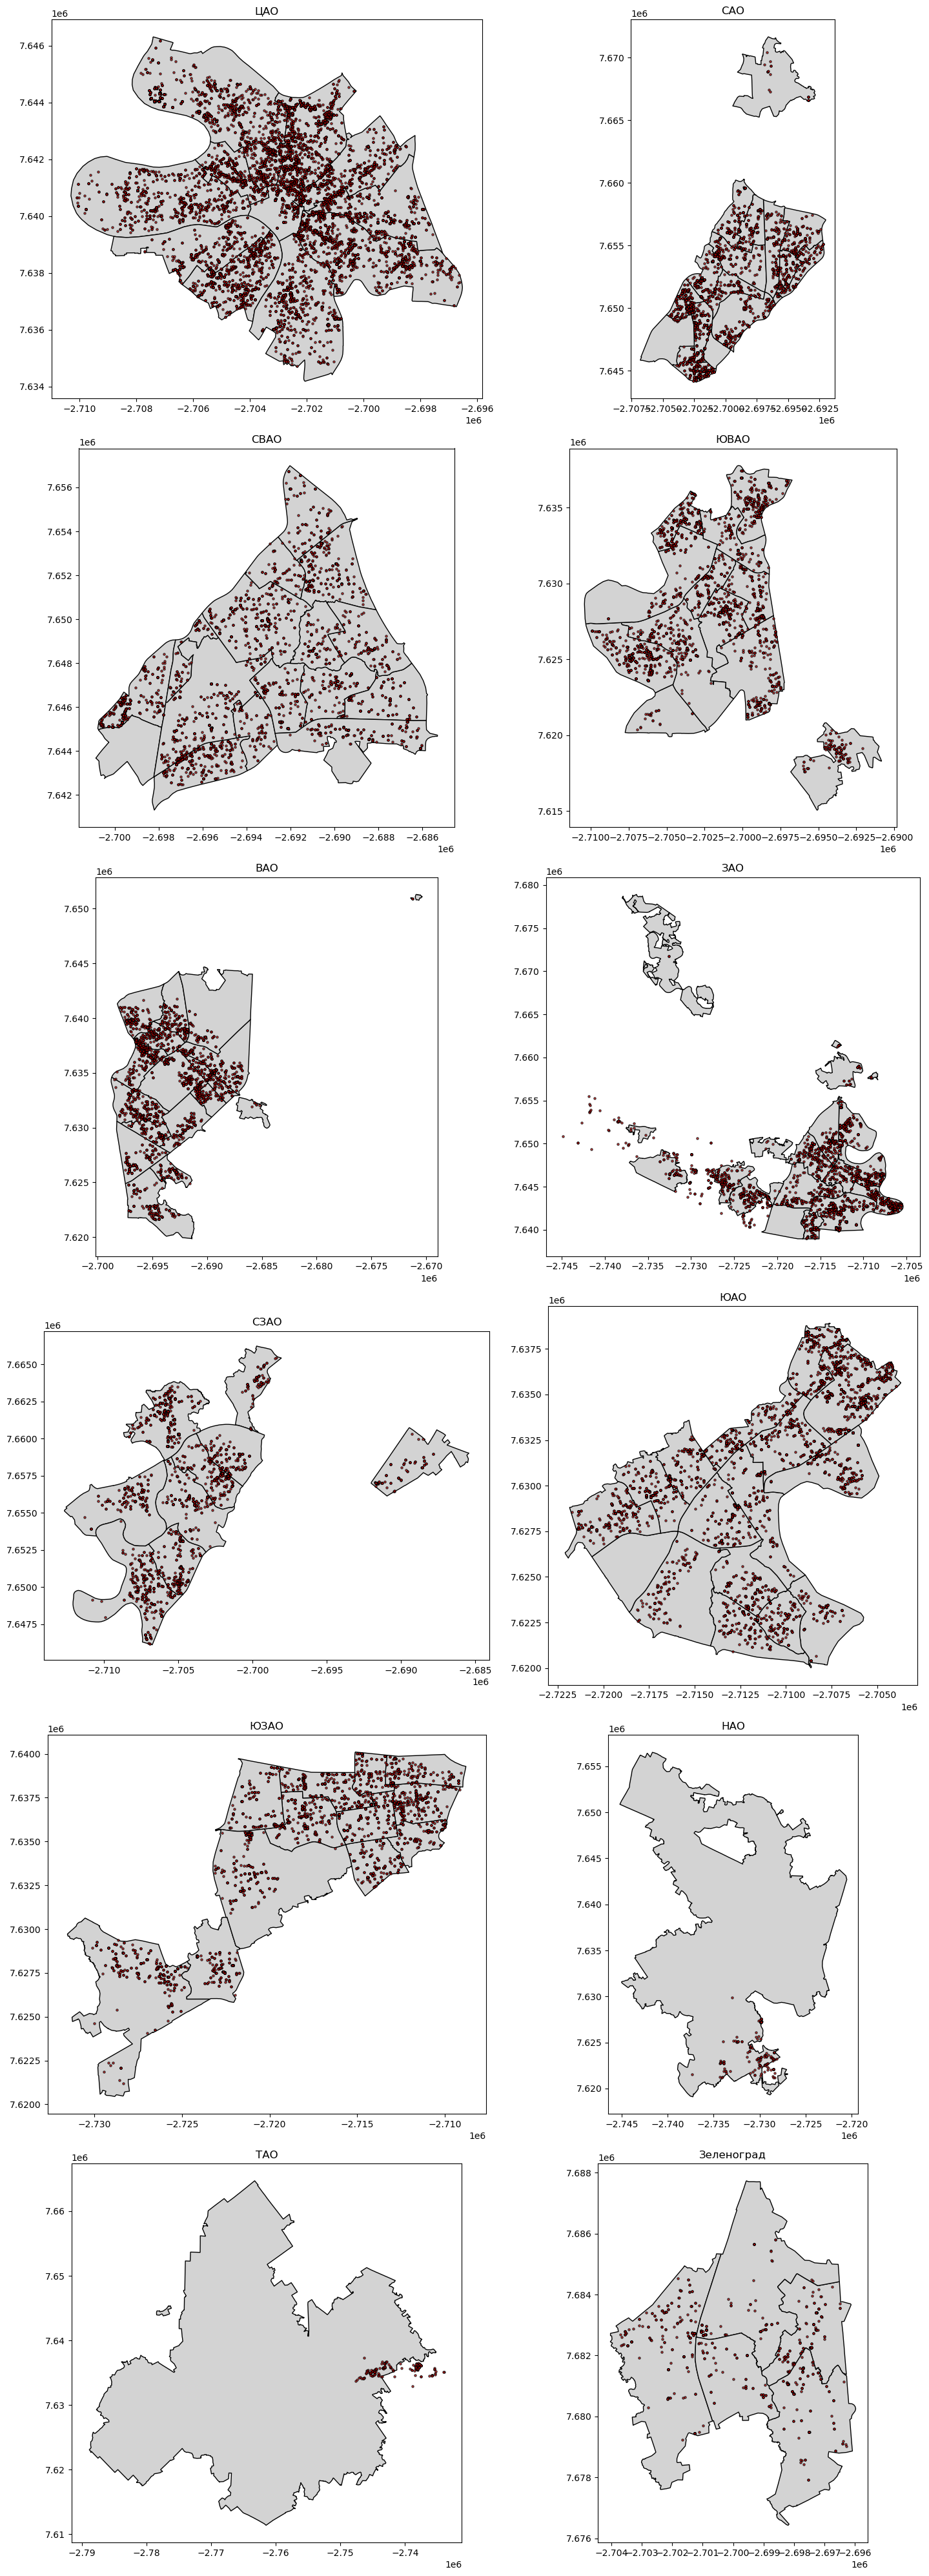

In [281]:
plt.figure(figsize=(15, 40))  # Создаем фигуру один раз

for i, okrug in enumerate(okrugs):
    plt.subplot(6, 2, (i + 1))  # Создаем подграфик
    ax = plt.gca()  # Получаем текущие оси (current axes) для этого подграфика

    df_geodict[okrug].plot(ax=ax, color='lightgray', edgecolor='black')

    gdf_cities = gpd.GeoDataFrame(df_dict[okrug], geometry=df_dict[okrug]['geoData'], crs="EPSG:4326")

    gdf_cities = gdf_cities.to_crs(df_geodict[okrug].crs)

    gdf_cities.plot(ax=ax, marker='.', color='red', markersize=20, label='',alpha=0.7, edgecolor='black')  

    plt.title(okrug)

plt.tight_layout()
plt.show()


по графикам и по предыдущей диаграмме видно,что больше всего заведений расположено в округах ЦАО и ЮАО
посмотрим какие именно типы заведений встречаются чаще всего в ЦАО

In [299]:
data=df_dict['ЦАО'].groupby('TypeObject').agg(count=('ID','count')).reset_index().sort_values(by='count',ascending=False)
data['percent in city']=data['count']/DF.groupby('TypeObject').agg(count=('ID','count')).reset_index()['count']*100#процент заведений от общего кол-во по городу
data['percent in distict']=data['count']/df_dict['ЦАО'].shape[0]*100
data.sort_values(by='percent in distict',ascending=False)

,TypeObject,count,percent in city,percent in distict
4,кафе,4703,32.546713,44.914526
9,ресторан,2068,42.032520,19.749785
0,бар,1231,47.038594,11.756279
5,кафетерий,703,20.615836,6.713781
10,столовая,615,14.328984,5.873365
8,предприятие быстрого\n обслуживания,545,8.498363,5.204851
1,буфет,230,22.136670,2.196543
6,магазин\n (отдел кулинарии),162,19.518072,1.547130
3,закусочная,146,13.047364,1.394327
7,ночной клуб (дискотека),54,60.674157,0.515710


In [285]:
sum(data['count'])#всего заведений

10471

Топ 3 по кол-во заведений занимают такие типы объектов  как кафе,рестораны и бар,
в центре сосредоточены почти 32%,42%,47% от общего числа кафе ресторанов и баров соответсвенно, так же в центре находится почти 60% ночных клубов столицы,что подчеркивает роль этого округа в ночной жизни города. 

А вот такие заведения как буфеты, столовые , закусочные,предприятие быстрого обслуживания в центре найти сложнее так как они составляют лишь 2% , 6%, 1%, 5% от общаего числа заведений в центре соотвественно.

Рассмотреть какие заведения свойственны распологаться в спальных районах столицы и рассмотрим один из таких районов - ЦАО

In [301]:
data=df_dict['ЮАО'].groupby('TypeObject').agg(count=('ID','count')).reset_index().sort_values(by='count',ascending=False)
data['percent in city']=data['count']/DF.groupby('TypeObject').agg(count=('ID','count')).reset_index()['count']*100#процент заведений от общего кол-во по городу
data['percent in distict']=data['count']/df_dict['ЮАО'].shape[0]*100#процент заведения от общего числа заведений в этом округе
data.sort_values(by='percent in distict',ascending=False)

,TypeObject,count,percent in city,percent in distict
4,кафе,1495,10.346021,33.229607
8,предприятие быстрого\n обслуживания,1116,17.402152,24.805512
10,столовая,575,13.397018,12.780618
9,ресторан,424,8.617886,9.424317
5,кафетерий,388,11.378299,8.624139
0,бар,238,9.094383,5.290064
6,магазин\n (отдел кулинарии),86,10.361446,1.911536
3,закусочная,83,7.417337,1.844854
1,буфет,58,5.582291,1.289175
2,заготовочный цех,30,16.393443,0.666815


In [302]:
sum(data['count'])

4499

Как видим в ЮАО так же большое кол-во кафе , но вот по количеству заведений расположенных в этом районе столовые и предприятия быстрого обсуживания  смогли обойти рестораны и занимают 24% и 12% соотвественно.Так же заметен спад таких типов заведений как бары,ночнные клубы,буфетов.
Так же заметно и общее снижение количества заведений, так как в центре находится больше заведений типа кафе , чем в ЮАО всех заведений в совокупности

Меньше всего заведений встречаются в новых районах такихх как новой москве,зеленограде и ТАО 
Проанализируем эти районы и выявим наиболее типичные заведения для этих райнов

In [310]:
data=df_dict['НАО'].groupby('TypeObject').agg(count=('ID','count')).reset_index().sort_values(by='count',ascending=False)
data['percent']=data['count']/DF.groupby('TypeObject').agg(count=('ID','count')).reset_index()['count']*100#процент заведений от общего кол-во по городу
data['percent in distict']=data['count']/df_dict['НАО'].shape[0]*100#процент заведения от общего числа заведений в этом округе
data.sort_values(by='percent in distict',ascending=False)

,TypeObject,count,percent,percent in distict
3,кафе,75,6.702413,49.342105
6,предприятие быстрого\n обслуживания,42,5.060241,27.631579
8,столовая,10,0.155933,6.578947
4,кафетерий,7,0.048443,4.605263
7,ресторан,6,6.741573,3.947368
2,заготовочный цех,5,2.732240,3.289474
5,магазин\n (отдел кулинарии),4,0.117302,2.631579
0,бар,2,0.076423,1.315789
1,буфет,1,0.096246,0.657895


In [309]:
data=df_dict['ТАО'].groupby('TypeObject').agg(count=('ID','count')).reset_index().sort_values(by='count',ascending=False)
data['percent']=data['count']/DF.groupby('TypeObject').agg(count=('ID','count')).reset_index()['count']*100#процент заведений от общего кол-во по городу
data['percent in distict']=data['count']/df_dict['ТАО'].shape[0]*100#процент заведения от общего числа заведений в этом округе
data.sort_values(by='percent in distict',ascending=False)

,TypeObject,count,percent,percent in distict
3,кафе,55,4.915103,34.591195
4,кафетерий,38,0.262976,23.899371
6,предприятие быстрого\n обслуживания,31,3.734940,19.496855
0,бар,9,0.343905,5.660377
2,закусочная,8,4.371585,5.031447
8,столовая,7,0.109153,4.402516
7,ресторан,6,6.741573,3.773585
1,заготовочный цех,3,0.288739,1.886792
5,магазин\n (отдел кулинарии),2,0.058651,1.257862


In [308]:
data=df_dict['Зеленоград'].groupby('TypeObject').agg(count=('ID','count')).reset_index().sort_values(by='count',ascending=False)
data['percent']=data['count']/DF.groupby('TypeObject').agg(count=('ID','count')).reset_index()['count']*100#процент заведений от общего кол-во по городу
data['percent in distict']=data['count']/df_dict['Зеленоград'].shape[0]*100#процент заведения от общего числа заведений в этом округе
data.sort_values(by='percent in distict',ascending=False)

,TypeObject,count,percent,percent in distict
10,столовая,155,3.611370,25.704809
4,кафе,142,0.982699,23.548922
8,предприятие быстрого\n обслуживания,100,1.559333,16.583748
5,кафетерий,72,2.111437,11.940299
0,бар,49,1.872373,8.126036
9,ресторан,38,0.772358,6.301824
6,магазин\n (отдел кулинарии),18,2.168675,2.985075
3,закусочная,10,0.893655,1.658375
1,буфет,9,0.866218,1.492537
2,заготовочный цех,7,3.825137,1.160862


Как и в случаи с ЮАО для этих районов преобладают типы заведений как столовая,кафе и предприятие быстрого обслуживания,
что говорит о практической направленности заведений – они больше ориентированы на местных жителей, а не на туристов или гостей города.

ЦАО ориентирован на развлечения и досуг, что подтверждается высоким числом баров, ресторанов и ночных клубов.
Южные и спальные районы (ЮАО, ЮЗАО) больше ориентированы на повседневные заведения – столовые, буфеты и предприятия быстрого обслуживания.
Отдаленные районы имеют низкую плотность заведений, что связано с меньшей деловой и туристической активностью.
Таким образом, наибольшая концентрация заведений, ориентированных на отдых и развлечения, наблюдается в центре,
тогда как на периферии преобладают заведения быстрого питания и столовые, рассчитанные на местных жителей.

# Вывод 
## Типы объектов общественного питания
Кафе - самое большое количество заведений именного этого типа и составляет оно около 36.71%
Преприятия быстрого обслуживания - 16.29% от общего количество заведений в столице
Ресторан - 12.5% от общего количество заведений в столице
Меньше всего в Москве таких предприятия как ночной клуб и заготовочный цех от общего числа заведений они занимают менее 1%

## Сетевые заведения
1) Лишь 18.9% от общего числа заведений являются сетевыми 
2) Тенденция к созданию сетей наблюдается в заведениях типа магазин(отдел кулинарии) и в предприятиях быстрого обслуживания и составляют 43% и 32% соотвественно от общаего числа заведений в этих категориях
3) Реже всего сети встречаются в заведениях типа ночной клуб(дискотека),столовая, буфет
4) Наиболее большие сети встречаются в заведениях типа предприятия быстрого обслуживания и кафе и это такие заведения как
вкусно и точка	322
KFC	298
Шоколадница	283
Бургер Кинг	242
Крошка Картошка	157
Следует заметить ,что число заведений таких как вкусно и точки, бургер кинг или kfc может казаться ниже , так как некоторые из заведений зарегестрированы как рестораны , что может исказить общую картину этих заведений в гороже
5) По количеству сетей в категории лидирает кафе и составляет 2981

## Посадочные места
1) В Москве можно найти заведения с самым разным количеством посадочных мест, от небольших закусочных без мест до ночных клубов на 2500  человек.
2) Более 29000 заведений имеют посадочных мест в диапазоне [0,52]
3) Тип заведения оказывается существенное влияние на кол-во посадочных мест
4) В среднем число посадочных мест в сетевых заведениях больше чем в несетевых
5) Как таковых явных зависимостей между количеством мест и количеством заведений в сети найдено не было,но было замечено,что большенсто сетевых заведений имеют небольшое кол-во мест и небольшое кол-во заведений в сети,но так же были замечены и выбросы,с большим средним значением  посадочных мест в сети и кол-вом заведений в сети

## Расположение объектов общественного питания
1) Больше всего заведений расположено в ЦАО(10471) и составляют 26% от общего числа заведений расположенных в столице
2) Меньше всего заведений расположено в переферии города в таких районах, как Зеленоград,ТАО,НАО и составляют 1,53% 1,1% 4% от общего соответсвенно числа заведений в городе
3) В каждом районе преобладают разные типы заведений , но стоит отметить , что процент заведений типа кафе во всех районых высокий,что может говорить о том, что тип заведения кафе достаточно расплывчатый.

